# **Homework 1: COVID-19 Cases Prediction (Regression)**

Author: Chih-Yuan Chuang (r09921006)

Slides: https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.pdf  
Video: TBA

Objectives:
* Solve a regression problem with deep neural networks (DNN).
* Understand basic DNN training tips.
* Get familiar with PyTorch.

# **基於baseline的分析與改善**

* **feature選取**
  * 用panda觀察feature分佈，分析feature跟target間的相關度
  * 選取相關度較大的15個features做training
  * 測試後，使不使用state不影響訓練結果，基於保持model簡單的原則不使用state
* **損失函數**
  * 將原本的MSE改為RMSE
  * 實作後發現基本上不影響的training結果，但有助於直觀認識數據
* **L1/L2正則，避免overfitting**
  * 一開始，我training跟valid loss有較大的差距，我嘗試透過正則減少這個誤差，使用後確實可以將誤差從0.5減小到0.01
  * 後來發現，我的誤差主要肇因於有一個異常值在切training、 valid data時被切到valid了，重新切分後，training跟valid基本上沒有差距，正則的影響很小
* **network架構**
  * 在層數上的修改，基本上一定會overfitting
  * 在寬度上的修改則沒有太大的影響（一方面是我懶得慢慢調參）
* **超參數**
  * batch size不作調整，基本上只影響收斂速度跟震盪
  * learning rate改得更小，主要是方便我觀察變化
  * optimizer試了下adam，結果更差，其他就都沒什麼調了，~~主要也是懶~~
* **歸一化**
  * 原本範例code中是不同的dataset分別使用自己的mean跟std做歸一，這是不合理的，應該使用全部資料的mean跟data做歸一，才不會有太大的偏差
* **Train跟Valid dataset切分**
  * 改為隨機切分，保證資料分布相同
  * 由於資料集太小，建議多切幾次避免將異常值劃分到valid（k-fold應該是個比較好的做法）

# **Result**
* Public: 0.87970，pass strong baseline
* Private: 0.89165，pass strong baseline

# **總結**
* 原本以為第一個作業不會太難，因此隨便用keras寫了一個model，結果loss直接飆到1.9，只好好好的分析，於是我暑假開始的第一個週末就沒了
* 誠如李宏毅李宏毅教授所言，誰會在禮拜五晚上學ML啊

# **Download Data**

If the Google drive links are dead, you can download data from [kaggle](https://www.kaggle.com/c/ml2021spring-hw1/data), and upload data manually to the workspace

In [39]:
train_path = "covid.train.csv"
test_path = "covid.test.csv"

!gdown --id "19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF" --output covid.train.csv
!gdown --id "1CE240jLm2npU-tdz81-oVKEF3T2yfT1O" --output covid.test.csv

Downloading...
From: https://drive.google.com/uc?id=19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF
To: /content/covid.train.csv
100% 2.00M/2.00M [00:00<00:00, 9.36MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CE240jLm2npU-tdz81-oVKEF3T2yfT1O
To: /content/covid.test.csv
100% 651k/651k [00:00<00:00, 3.97MB/s]


# **Data Analysis**

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 讀取測資
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

In [41]:
# 資料筆數
print ("Train: {:4d}".format(len(train_data)))
print (" Test: {:4d}".format(len(test_data)))

Train: 2700
 Test:  893


In [42]:
# feature名稱、型別、空值
print (train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 95 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      2700 non-null   int64  
 1   AL                      2700 non-null   float64
 2   AK                      2700 non-null   float64
 3   AZ                      2700 non-null   float64
 4   AR                      2700 non-null   float64
 5   CA                      2700 non-null   float64
 6   CO                      2700 non-null   float64
 7   CT                      2700 non-null   float64
 8   FL                      2700 non-null   float64
 9   GA                      2700 non-null   float64
 10  ID                      2700 non-null   float64
 11  IL                      2700 non-null   float64
 12  IN                      2700 non-null   float64
 13  IA                      2700 non-null   float64
 14  KS                      2700 non-null   

In [43]:
# 觀察上下界及均值，去掉id跟state資料
train_data.iloc[:, 41:].describe()

,cli,ili,hh_cmnty_cli,nohh_cmnty_cli,wearing_mask,travel_outside_state,work_outside_home,shop,restaurant,spent_time,large_event,public_transit,anxious,depressed,felt_isolated,worried_become_ill,worried_finances,tested_positive,cli.1,ili.1,hh_cmnty_cli.1,nohh_cmnty_cli.1,wearing_mask.1,travel_outside_state.1,work_outside_home.1,shop.1,restaurant.1,spent_time.1,large_event.1,public_transit.1,anxious.1,depressed.1,felt_isolated.1,worried_become_ill.1,worried_finances.1,tested_positive.1,cli.2,ili.2,hh_cmnty_cli.2,nohh_cmnty_cli.2,wearing_mask.2,travel_outside_state.2,work_outside_home.2,shop.2,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2,tested_positive.2
count,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000
mean,0.991587,1.016136,29.442496,24.323054,89.682322,8.894498,31.703307,55.277153,16.694342,36.283177,10.352273,2.393285,18.074684,13.075498,19.213321,64.633769,44.519474,16.300893,0.994568,1.019135,29.529305,24.402875,89.736737,8.861371,31.664651,55.198075,16.635440,36.176886,10.304595,2.389372,18.071667,13.067127,19.228457,64.734139,44.544124,16.366695,0.997986,1.022472,29.610807,24.477913,89.790227,8.830759,31.624272,55.119903,16.578290,36.074941,10.257474,2.385735,18.067635,13.058828,19.243283,64.834307,44.568440,16.431280
std,0.420296,0.423629,9.093738,8.446750,5.380027,3.404027,4.928902,4.525917,5.668479,6.675206,4.698705,1.053270,2.248750,1.621328,2.706605,6.232239,5.265787,7.637823,0.420114,0.423538,9.082940,8.443146,5.366067,3.389310,4.916168,4.524887,5.660085,6.664218,4.692479,1.053237,2.249864,1.625269,2.707148,6.226622,5.248787,7.627538,0.420205,0.423705,9.070537,8.437044,5.351574,3.377722,4.901857,4.524442,5.651583,6.655166,4.686263,1.053147,2.250081,1.628589,2.708339,6.220087,5.232030,7.619354
min,0.126321,0.132470,9.961640,6.857181,70.950912,1.252983,18.311941,43.220187,3.637414,21.485815,2.118674,0.728770,12.980786,8.370536,13.400399,48.225603,33.113882,2.338708,0.126321,0.132470,9.961640,6.857181,72.330064,1.252983,18.311941,43.220187,3.637414,21.485815,2.118674,0.728770,12.980786,8.370536,13.400399,48.225603,33.113882,2.338708,0.126321,0.132470,9.961640,6.857181,72.356322,1.252983,18.311941,43.220187,3.637414,21.485815,2.118674,0.728770,12.980786,8.370536,13.400399,48.225603,33.113882,2.338708
25%,0.673929,0.697515,23.203165,18.539153,86.309537,6.177754,28.247865,51.547206,13.311050,30.740931,6.653427,1.720601,16.420485,11.943953,17.292063,59.529326,40.520369,10.200722,0.676205,0.699773,23.264324,18.607342,86.386111,6.168986,28.202745,51.403036,13.248788,30.646955,6.605724,1.715372,16.423140,11.933745,17.303887,59.703583,40.533768,10.251453,0.680065,0.703390,23.307794,18.644297,86.436468,6.159286,28.187875,51.262363,13.200532,30.606711,6.532543,1.714080,16.420485,11.914167,17.322912,59.782876,40.549987,10.327314
50%,0.912747,0.940295,28.955738,23.819761,90.819435,8.288288,32.143140,55.257262,16.371699,36.267966,9.802380,2.204258,17.685476,12.963659,18.735807,65.688024,43.911769,15.479766,0.917343,0.942587,29.061296,23.905188,90.859943,8.274067,32.108420,55.129326,16.293314,36.169954,9.738629,2.203602,17.684970,12.956723,18.745824,65.783579,43.947131,15.572281,0.920815,0.948001,29.137273,24.010817,90.912271,8.251691,32.051128,54.990445,16.227010,36.041389,9.700368,2.199521,17.684197,12.948749,18.760267,65.932258,43.997637,15.646480


In [44]:
# 與train資料做對比，判斷是否來自同一分佈
test_data.iloc[:, 41:].describe()

,cli,ili,hh_cmnty_cli,nohh_cmnty_cli,wearing_mask,travel_outside_state,work_outside_home,shop,restaurant,spent_time,large_event,public_transit,anxious,depressed,felt_isolated,worried_become_ill,worried_finances,tested_positive,cli.1,ili.1,hh_cmnty_cli.1,nohh_cmnty_cli.1,wearing_mask.1,travel_outside_state.1,work_outside_home.1,shop.1,restaurant.1,spent_time.1,large_event.1,public_transit.1,anxious.1,depressed.1,felt_isolated.1,worried_become_ill.1,worried_finances.1,tested_positive.1,cli.2,ili.2,hh_cmnty_cli.2,nohh_cmnty_cli.2,wearing_mask.2,travel_outside_state.2,work_outside_home.2,shop.2,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2
count,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000
mean,0.972457,0.991809,29.075682,24.018729,89.637506,9.001325,31.620607,55.422982,16.554387,36.371653,10.356177,2.382769,18.030215,13.020293,19.230715,64.406944,44.379019,15.976544,0.977508,0.997195,29.133016,24.076375,89.715077,8.955668,31.541307,55.360132,16.510614,36.268780,10.309059,2.376621,18.013300,13.007566,19.220921,64.527609,44.386619,15.989196,0.981119,1.000032,29.192015,24.117403,89.765373,8.917700,31.513665,55.268628,16.444916,36.165898,10.248975,2.369115,17.988147,12.993830,19.238723,64.619920,44.411505
std,0.411997,0.415468,9.596290,8.988245,4.733549,3.655616,4.754570,4.366780,5.688802,6.203232,4.521531,1.114568,2.235211,1.715389,2.689158,5.721753,4.579553,7.813659,0.413665,0.418835,9.527793,8.920860,4.708376,3.651532,4.734470,4.374390,5.686128,6.195079,4.508985,1.119861,2.210427,1.705901,2.674568,5.694758,4.612057,7.786780,0.413244,0.418081,9.467570,8.865726,4.692231,3.637221,4.733639,4.350540,5.656828,6.192274,4.498845,1.114366,2.207022,1.713143,2.687435,5.685865,4.605268
min,0.139558,0.159477,9.171315,6.014740,76.895278,2.062500,18.299198,44.062442,3.800684,21.487077,2.324264,0.785854,12.853772,8.453722,13.269686,50.303447,35.432447,1.339310,0.152059,0.166967,9.207952,5.750693,76.895363,2.009744,18.154712,45.209752,3.549729,21.337579,2.285853,0.839549,12.968745,8.491336,13.177680,49.993134,34.663854,1.351363,0.049938,0.065544,9.459442,6.034050,77.025654,2.000000,18.278377,44.671891,3.837441,21.338425,2.334654,0.873986,12.696977,8.462444,13.476209,50.212234,35.072577
25%,0.673327,0.689367,21.831730,17.385490,86.587475,7.055039,28.755178,51.726987,13.314242,31.427591,6.832898,1.786206,16.463262,11.800174,17.164105,60.070159,40.683578,9.982916,0.667296,0.684726,21.967645,17.602241,86.761239,7.043880,28.713787,51.686774,13.275460,31.324347,6.890855,1.775599,16.502816,11.806194,17.101370,60.267099,40.912076,10.070058,0.677422,0.691911,22.145670,17.687770,86.799638,6.908287,28.730951,51.594301,13.391769,31.330469,6.802860,1.760374,16.406397,11.777101,17.197313,60.358203,40.910546
50%,0.925230,0.936610,28.183014,23.035749,90.123133,8.773243,31.826385,55.750887,17.100556,36.692799,9.734692,2.173884,17.750598,12.819747,19.154800,64.744199,44.459526,15.435832,0.919533,0.944818,28.177370,23.094211,90.142711,8.727310,31.647384,55.784308,17.064074,36.405847,9.712576,2.155570,17.783846,12.824065,19.094616,64.967013,44.485451,15.381420,0.931789,0.944038,28.137863,23.116177,90.182055,8.682130,31.525946,55.490325,16.975410,36.213594,9.550393,2.146468,17.719760,12.805424,19.068658,65.148128,44.504010
75%,1.251219,1.267463,36.813772,31.141866,93.387952,10.452262,35.184926,59.185350,20.919961,41.265159,13.637503,2.650302,19.455838,1

In [45]:
# 判斷feature跟target之間的相關度
# 列出相關度大於0.4的features

corr = train_data.iloc[:, 41:].corr().iloc[-1]
features = corr[abs(corr) > 0.4]
features_col = features.index.to_list()[:-1]
features_id = np.array([train_data.columns.to_list().index(i) for i in features_col]) - 1

print (features)
print ("\nfeatures' id:", features_id)

cli                   0.838504
ili                   0.830527
hh_cmnty_cli          0.879724
nohh_cmnty_cli        0.869938
shop                 -0.410430
public_transit       -0.448360
worried_finances      0.475462
tested_positive       0.981165
cli.1                 0.838224
ili.1                 0.829200
hh_cmnty_cli.1        0.879438
nohh_cmnty_cli.1      0.869278
shop.1               -0.412705
public_transit.1     -0.449079
worried_finances.1    0.480958
tested_positive.1     0.991012
cli.2                 0.835751
ili.2                 0.826075
hh_cmnty_cli.2        0.878218
nohh_cmnty_cli.2      0.867535
shop.2               -0.415130
public_transit.2     -0.450436
worried_finances.2    0.485843
tested_positive.2     1.000000
Name: tested_positive.2, dtype: float64

features' id: [40 41 42 43 47 51 56 57 58 59 60 61 65 69 74 75 76 77 78 79 83 87 92]


# **Import Packages**

In [46]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# For data preprocess
import numpy as np
import csv
import os

my_seed = 0
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(my_seed)
torch.manual_seed(my_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(my_seed)

# **Utilities**

In [47]:
def get_device():
    """ Get device (if GPU is available, use GPU) """
    return "cuda" if torch.cuda.is_available() else "cpu"

# **Dataset**

The `COVID19Dataset` below does:
* read `.csv` files
* extract features
* split `covid.train.csv` into train/dev sets
* normalize features

In [48]:
class COVID19Dataset(Dataset):
    """ Dataset for loading and preprocessing the COVID19 dataset """
    def __init__(self, path, mode, valid_rate, mean, std):
        with open(path, "r") as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float)

        # 使不使用state
        # choose_features = [i for i in range(40)]
        choose_features = []

        # 使用corr較大的feature
        choose_features.extend([40, 41, 42, 43, 57, 58, 59, 60, 61, 75, 76, 77, 78, 79, 92])

        if mode == "test":        
            self.x = torch.FloatTensor(data[:, choose_features])
        else:
            train_indices, valid_indices = train_test_split([i for i in range(data.shape[0])], test_size=valid_rate, random_state=1)
            if mode == "train":
                self.x = torch.FloatTensor(data[train_indices, :])
                self.y = torch.FloatTensor(data[train_indices, 93])
            elif mode == "valid":
                self.x = torch.FloatTensor(data[valid_indices, :])
                self.y = torch.FloatTensor(data[valid_indices, 93])
            self.x = self.x[:, choose_features]
        
        self.mean = mean
        self.std = std
            
        # 使不使用state
        # self.x[:,40:] = (self.x[:, 40:] - self.mean) / self.std
        self.x[:, :] = (self.x[:, :] - self.mean) / self.std

        self.mode = mode
        self.features_num = self.x.shape[1]


    def __getitem__(self, index):
        if self.mode in ["train", "valid"]:
            return self.x[index], self.y[index]
        else:
            return self.x[index]
    

    def __len__(self):
        return len(self.x)

# **DataLoader**

A `DataLoader` loads data from a given `Dataset` into batches.


In [49]:
def prepare_dataloader(path, mode, valid_rate, batch_size, jobs_num, mean, std):
    dataset = COVID19Dataset(path, mode, valid_rate, mean, std)
    dataloader = DataLoader(dataset, batch_size, shuffle=(mode=="train"), drop_last=False, num_workers=jobs_num, pin_memory=True)
    return dataloader

# **Deep Neural Network**

`NeuralNet` is an `nn.Module` designed for regression.
The DNN consists of 2 fully-connected layers with ReLU activation.
This module also included a function `cal_loss` for calculating loss.


In [50]:
class NeuralNetwork(nn.Module):
    def __init__(self, features_num):
        super(NeuralNetwork, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(features_num, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.criterion = nn.MSELoss(reduction="mean")
    

    def forward(self, x):
        """ Given input of size (batch_size x input_dim), compute output of the network """
        return self.network(x).squeeze(1)


    def cal_loss(self, y, y_hat):
        """ Calculate loss """
        loss = torch.sqrt(self.criterion(y, y_hat))
        # l2 = 0
        # for i in self.parameters():
        #     l2 += torch.sum(torch.pow(i, 2))
        # return loss + 0.01 * l2, loss  
        l1 = 0
        for i in self.parameters():
            l1 += torch.sum(abs(i))
        return loss + 0.0001 * l1, loss  

## **Training**

In [51]:
def train(train_dataloader, valid_dataloader, model, config, device):
    optimizer = getattr(torch.optim, config["optimizer"])(model.parameters(), **config["optimizer_hparas"])

    rmse_min = float("Inf")
    not_better_cnt = 0
    epoch = 0

    while epoch < config["epochs_num"]:
        model.train()
        train_loss = 0
        for x, y in train_dataloader:
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            rmse_l1_loss, rmse_loss = model.cal_loss(y, y_hat)
            rmse_l1_loss.backward()
            optimizer.step()  
            train_loss += rmse_loss.detach().cpu().item() * x.shape[0]
        train_loss /= len(train_dataloader.dataset)

        model.eval()
        valid_loss = 0
        for x, y in valid_dataloader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():   
                y_hat = model(x)
                rmse_l1_loss, rmse_loss = model.cal_loss(y, y_hat)
            valid_loss += rmse_loss.detach().cpu().item() * x.shape[0]
        valid_loss /= len(valid_dataloader.dataset)
    
        print ("Epoch: {:4d}, Train Loss: {:.4f}, Valid Loss: {:.4f}".format(epoch + 1, train_loss, valid_loss))

        if valid_loss < rmse_min:
            rmse_min = valid_loss
            torch.save(model.state_dict(), config["save_path"]) 
            not_better_cnt = 0
        else:
            not_better_cnt += 1
        
        if not_better_cnt > config["early_stop"]:
            print ("Early stop at epoch {:4d}.".format(epoch + 1))
            break
        epoch += 1

# **Setup Hyper-parameters**

`config` contains hyper-parameters for training and the path to save your model.

In [52]:
device = get_device()
os.system("mkdir models")

config = {
    "epochs_num": 20000,
    "batch_size": 270,
    "optimizer": "SGD", 
    "optimizer_hparas": {  
        "lr": 0.0001,
        "momentum": 0.9
    },
    "early_stop": 200,
    "save_path": "models/model.pth" 
}

# **Load data and model**

In [53]:
# 全部測資一起算mean、std
with open(train_path, "r") as fp:
    train_data = list(csv.reader(fp))
    train_data = np.array(train_data[1:])[:, 1:-1].astype(float)
with open(test_path, "r") as fp:
    test_data = list(csv.reader(fp))
    test_data = np.array(test_data[1:])[:, 1:].astype(float)
all_data = np.vstack([train_data, test_data])

id = [40, 41, 42, 43, 57, 58, 59, 60, 61, 75, 76, 77, 78, 79, 92]
mean = torch.FloatTensor(train_data[:, id]).mean(dim=0, keepdim=True)
std = torch.FloatTensor(train_data[:, id]).std(dim=0, keepdim=True)

train_dataloader = prepare_dataloader(train_path, "train", 0.1, config["batch_size"], 0, mean, std)
valid_dataloader = prepare_dataloader(train_path, "valid", 0.1, config["batch_size"], 0, mean, std)
test_dataloader = prepare_dataloader(test_path, "test", None, config["batch_size"], 0, mean, std)

In [54]:
model = NeuralNetwork(train_dataloader.dataset.features_num).to(device) 

# **Start Training**

In [55]:
train(train_dataloader, valid_dataloader, model, config, device)

Epoch:    1, Train Loss: 17.8940, Valid Loss: 17.8164
Epoch:    2, Train Loss: 17.8661, Valid Loss: 17.7811
Epoch:    3, Train Loss: 17.8246, Valid Loss: 17.7390
Epoch:    4, Train Loss: 17.7812, Valid Loss: 17.6941
Epoch:    5, Train Loss: 17.7329, Valid Loss: 17.6475
Epoch:    6, Train Loss: 17.6854, Valid Loss: 17.6002
Epoch:    7, Train Loss: 17.6331, Valid Loss: 17.5522
Epoch:    8, Train Loss: 17.5882, Valid Loss: 17.5036
Epoch:    9, Train Loss: 17.5378, Valid Loss: 17.4544
Epoch:   10, Train Loss: 17.4877, Valid Loss: 17.4046
Epoch:   11, Train Loss: 17.4269, Valid Loss: 17.3540
Epoch:   12, Train Loss: 17.3863, Valid Loss: 17.3027
Epoch:   13, Train Loss: 17.3315, Valid Loss: 17.2502
Epoch:   14, Train Loss: 17.2802, Valid Loss: 17.1976
Epoch:   15, Train Loss: 17.2276, Valid Loss: 17.1439
Epoch:   16, Train Loss: 17.1689, Valid Loss: 17.0892
Epoch:   17, Train Loss: 17.1131, Valid Loss: 17.0336
Epoch:   18, Train Loss: 17.0562, Valid Loss: 16.9763
Epoch:   19, Train Loss: 16.

# **Visualize Result**

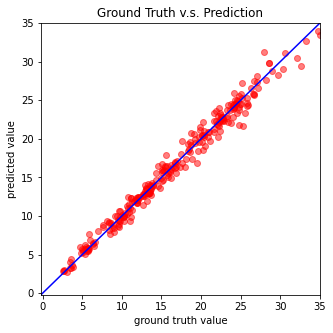

In [56]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def plot_pred(dataloader, model, device, lim=35., y_hats=None, y_targets=None):
    """ Plot prediction of your DNN """
    if y_hats is None or y_targets is None:
        model.eval()
        y_hats, y_targets = [], []
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                y_hat = model(x)
                y_hats.append(y_hat.detach().cpu())
                y_targets.append(y.detach().cpu())
        y_hats = torch.cat(y_hats, dim=0).numpy()
        y_targets = torch.cat(y_targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(y_targets, y_hats, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel("ground truth value")
    plt.ylabel("predicted value")
    plt.title("Ground Truth v.s. Prediction")
    plt.show()

del model
model = NeuralNetwork(train_dataloader.dataset.features_num).to(device)
ckpt = torch.load(config["save_path"], map_location="cpu")  
model.load_state_dict(ckpt)
plot_pred(valid_dataloader, model, device)  

# **Save Output**

In [57]:
def test(test_dataloader, model, device):
    model.eval()                               
    y_hats = []
    for x in test_dataloader:                         
        x = x.to(device)                       
        with torch.no_grad():                   
            y_hat = model(x)                     
            y_hats.append(y_hat.detach().cpu())  
    y_hats = torch.cat(y_hats, dim=0).numpy()     
    return y_hats

def save_y_hat(y_hats, file):
    """ Save predictions to specified file """
    print("Saving results to {}".format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(["id", "tested_positive"])
        for i, y in enumerate(y_hats):
            writer.writerow([i, y])

y_hats = test(test_dataloader, model, device) 
save_y_hat(y_hats, "y_hat.csv")      

Saving results to y_hat.csv


# **Reference**

Source: Heng-Jui Chang @ NTUEE (https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb)
